In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)

In [2]:
df_sales_train = pd.read_hdf("../input/sales_train.h5")
df_sales_test = pd.read_hdf("../input/sales_test.h5")

In [3]:
df_sales_train["date"] = pd.to_datetime(df_sales_train["date"], dayfirst=True)
df_sales_test["date"] = pd.to_datetime(df_sales_test["date"], dayfirst=True)

In [4]:
df_sales_train['week'] = df_sales_train['date'].dt.isocalendar().week
df_sales_test['week'] = df_sales_test['date'].dt.isocalendar().week

df_sales_train['month'] = df_sales_train['date'].dt.month
df_sales_test['month'] = df_sales_test['date'].dt.month

In [5]:
df_sales_train.sample(3)

,id,weekly_sales,store,dept,date,is_holiday,week,month
41322,41322,62325.539062,8,92,2010-08-13,False,32,8
197939,197939,4821.700195,28,6,2011-04-15,False,15,4
251360,251360,124.120003,22,94,2011-12-09,False,49,12


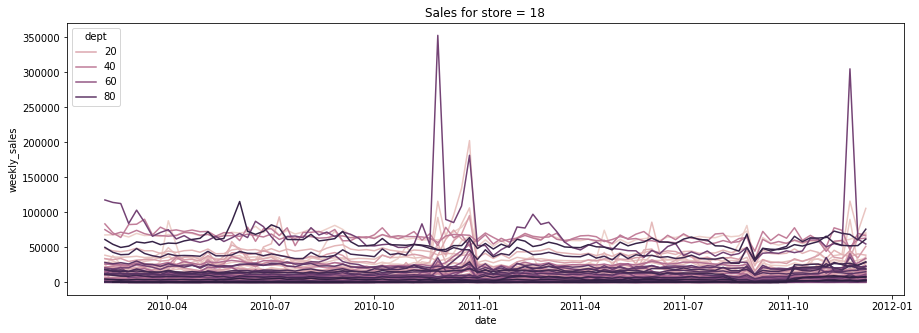

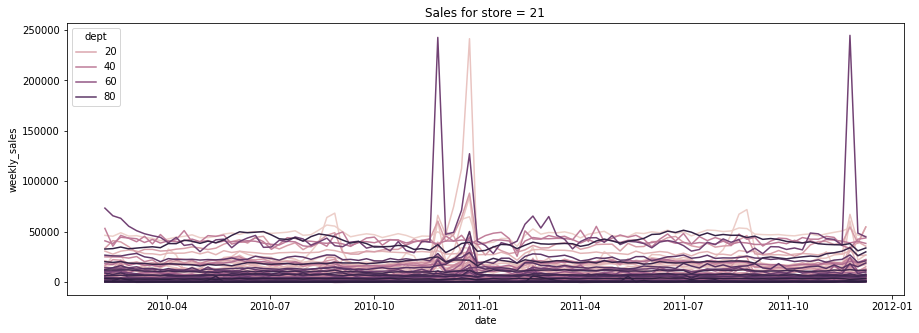

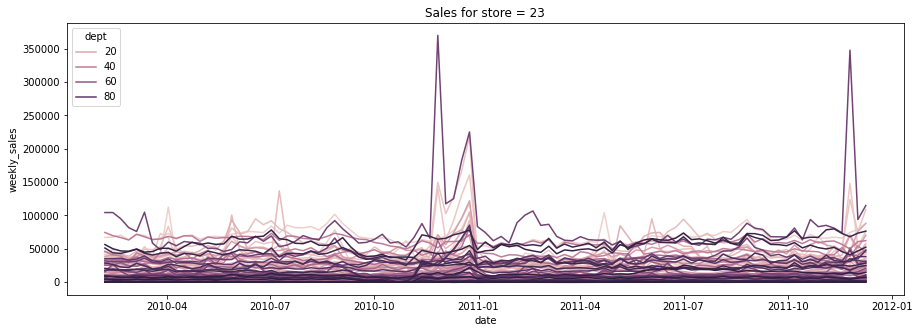

In [6]:
for i in range(3):
    random_store = df_sales_train.store.sample().values[0]
    plt.title("Sales for store = {}".format(random_store))
    sns.lineplot(x='date', y='weekly_sales', hue="dept", data=df_sales_train[df_sales_train.store == random_store]);
    plt.show()

### Dołączenie danych o średniej sprzedaży

### Dodatkowa charakterystyka sklepu
Średnioroczna sprzedaż per sklep

In [7]:
df_store_agg = df_sales_train.groupby(["store"])["weekly_sales"].agg(["mean", "std", "median", "size"]).reset_index()
df_store_agg.head()

,store,mean,std,median,size
0,1,21374.376953,27255.341955,10253.300781,6950
1,2,26863.833984,32835.166002,14412.969727,6937
2,3,6226.871582,15078.119041,2693.699951,6117
3,4,28493.947266,33695.399996,14835.009766,6960
4,5,4936.753418,7837.545720,2524.500000,6101


In [8]:
df_store_agg.rename(columns={'mean': 'store_mean', 'std':'store_std', 'median':'store_median', 'size':'store_agg_size'}, inplace=True)

In [9]:
df_sales_train = pd.merge(df_sales_train, df_store_agg, how='left', on='store')
df_sales_test = pd.merge(df_sales_test, df_store_agg, how='left', on='store') 

In [10]:
df_sales_train.sample(3)

,id,weekly_sales,store,dept,date,is_holiday,week,month,store_mean,store_std,store_median,store_agg_size
272924,403551,11889.459961,9,79,2010-06-04,False,22,6,8636.435547,12391.599321,4166.640137,5981
175283,259244,1600.680054,15,27,2011-10-07,False,40,10,9183.611328,11850.500597,4894.140137,6713
28605,42448,1587.229980,45,19,2010-03-19,False,11,3,11676.592773,14139.924920,6029.915039,6526


Średnia sprzedaż w departamencie

In [11]:
df_dept_agg = df_sales_train.groupby(['store', 'dept'])["weekly_sales"].agg(["mean", "std", "median", "size"]).reset_index()
df_dept_agg.head()

,store,dept,mean,std,median,size
0,1,1,22494.710938,9784.865055,18820.289062,97
1,1,2,45666.632812,3038.616183,45222.300781,97
2,1,3,12785.541992,8479.493226,10136.780273,97
3,1,4,36428.882812,2818.775517,36174.429688,97
4,1,5,24401.593750,12340.451510,21183.419922,97


In [12]:
df_dept_agg.rename(columns={'mean': 'dept_mean', 'std':'dept_std', 'median':'dept_median', 'size':'dept_agg_size'}, inplace=True)

In [13]:
df_sales_train = pd.merge(df_sales_train, df_dept_agg, how='left', on=['store', 'dept']).fillna(-1)
df_sales_test = pd.merge(df_sales_test, df_dept_agg, how='left', on=['store', 'dept']).fillna(-1)

In [14]:
df_sales_test.sample(3)

,id,store,dept,date,is_holiday,week,month,store_mean,store_std,store_median,store_agg_size,dept_mean,dept_std,dept_median,dept_agg_size
129695,400832,15,87,2012-08-31,False,35,8,9183.611328,11850.500597,4894.140137,6713,8676.024414,1198.749940,8570.200195,97.0
14923,45756,22,46,2012-09-07,True,36,9,15276.317383,18621.194712,8481.080078,6554,21854.121094,3891.018665,21077.220703,97.0
35269,108760,40,67,2012-06-15,False,24,6,13721.232422,17505.165063,7274.859863,6777,6742.185547,2385.581503,5947.189941,97.0


---

### Features - z dodatkowego pliku

In [15]:
df_features_train = pd.read_hdf("../input/features_train.h5")
df_features_test = pd.read_hdf("../input/features_test.h5")
df_features_train["date"] = pd.to_datetime(df_features_train["date"], dayfirst=True)
df_features_test["date"] = pd.to_datetime(df_features_test["date"], dayfirst=True)

In [16]:
print(df_features_train.shape, df_features_test.shape)

(4365, 12) (3825, 3)


In [17]:
df_features_train['week'] = df_features_train['date'].dt.isocalendar().week
df_features_test['week'] = df_features_test['date'].dt.isocalendar().week

In [18]:
df_features_train.sample(3)

,store,date,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,is_holiday,week
7004,39,2011-10-14,23.218750,3.273438,NaN,NaN,NaN,NaN,NaN,216.125,7.714844,False,41
1837,11,2010-06-04,26.484375,2.705078,NaN,NaN,NaN,NaN,NaN,214.500,7.343750,False,22
3189,18,2011-12-02,7.917969,3.501953,4616.0,7.0,1389.0,2420.0,23232.0,136.500,8.468750,False,48


In [19]:
df_features_test.sample(3)

,store,date,is_holiday,week
1384,8,2012-03-16,False,11
8129,45,2012-06-01,False,22
6715,37,2013-03-22,False,12


In [20]:
print('Train min:', df_features_train['date'].min())
print('Train max:', df_features_train['date'].max())
print()
print('Test min:', df_features_test['date'].min())
print('Test max:', df_features_test['date'].max())

Train min: 2010-02-05 00:00:00
Train max: 2011-12-09 00:00:00

Test min: 2011-12-16 00:00:00
Test max: 2013-07-26 00:00:00


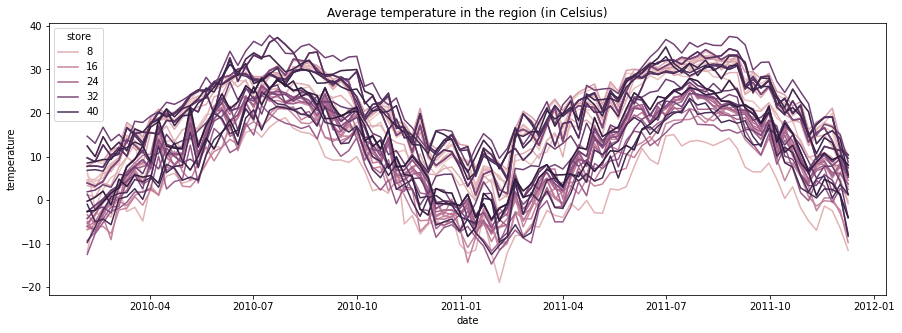

In [21]:
plt.title("Average temperature in the region (in Celsius)")
sns.lineplot(x='date', y='temperature', hue='store', data=df_features_train);

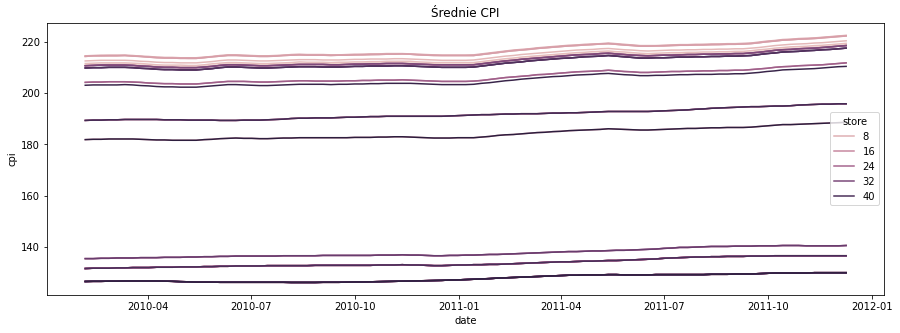

In [22]:
plt.title("Średnie CPI")
sns.lineplot(x='date', y='cpi', hue='store', data=df_features_train);

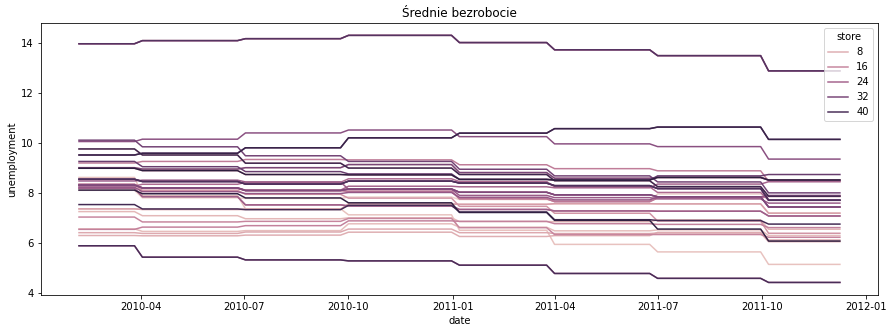

In [23]:
plt.title("Średnie bezrobocie")
sns.lineplot(x='date', y='unemployment', hue='store', data=df_features_train);

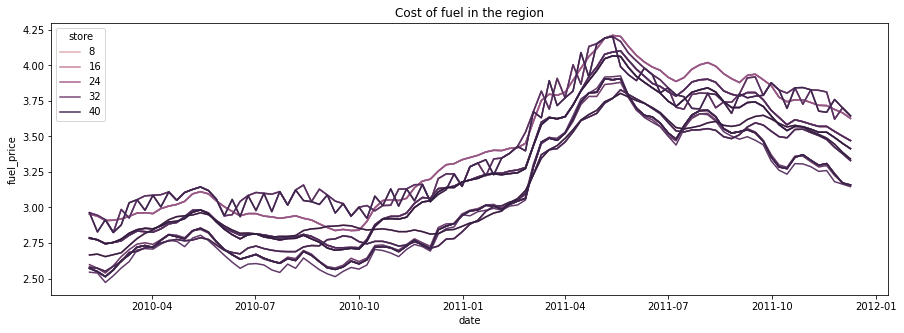

In [24]:
plt.title("Cost of fuel in the region")
sns.lineplot(x='date', y='fuel_price', hue='store', data=df_features_train);

In [25]:
df_features_train.sample(5)

,store,date,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,is_holiday,week
5643,32,2010-02-12,-2.171875,2.572266,NaN,NaN,NaN,NaN,NaN,189.5000,9.015625,True,6
6199,35,2010-04-23,12.171875,2.902344,NaN,NaN,NaN,NaN,NaN,135.8750,9.054688,False,16
2814,16,2011-09-16,12.046875,3.595703,NaN,NaN,NaN,NaN,NaN,194.7500,6.339844,False,37
5101,29,2010-03-12,6.351562,2.804688,NaN,NaN,NaN,NaN,NaN,131.7500,10.062500,False,10
5828,33,2010-03-05,15.093750,2.876953,NaN,NaN,NaN,NaN,NaN,126.5625,10.117188,False,9


In [26]:
df_features_test.sample(5)

,store,date,is_holiday,week
465,3,2012-01-13,False,2
4530,25,2013-03-15,False,11
332,2,2012-12-21,False,51
6690,37,2012-09-28,False,39
6160,34,2013-01-18,False,3


### Agregacja dodatkowych cech
#### Temperatura
Cechy mamy per sklep i tydzień

In [27]:
df_temp_agg = df_features_train.groupby(['store', 'week']).agg(['mean'])[['temperature']].reset_index()

In [28]:
df_temp_agg.columns = [' '.join(col).strip() for col in df_temp_agg.columns.values]
df_temp_agg.columns = [col.replace(' ', '_') for col in df_temp_agg.columns.values]

In [29]:
df_temp_agg.sample(3)

,store,week,temperature_mean
685,14,10,7.445312
270,6,11,16.000000
17,1,18,20.312500


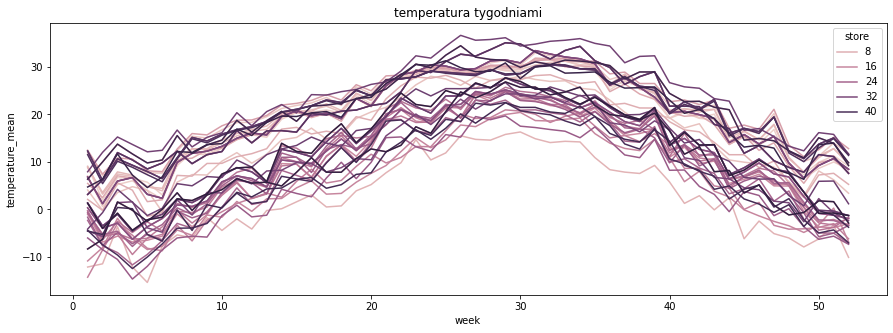

In [30]:
plt.title("temperatura tygodniami")
sns.lineplot(x='week', y='temperature_mean', hue='store', data=df_temp_agg);

In [31]:
df_sales_train = pd.merge(df_sales_train, df_temp_agg, how='left', on=['store', 'week'])
df_sales_test = pd.merge(df_sales_test, df_temp_agg, how='left', on=['store', 'week'])

In [32]:
df_sales_train.sample(3)

,id,weekly_sales,store,dept,date,is_holiday,week,month,store_mean,store_std,store_median,store_agg_size,dept_mean,dept_std,dept_median,dept_agg_size,temperature_mean
183569,271463,10922.040039,21,3,2011-05-06,False,18,5,11532.441406,13377.887499,6919.970215,6473,14373.730469,13051.762461,9970.900391,97,19.093750
277635,410448,11351.389648,21,1,2010-07-23,False,29,7,11532.441406,13377.887499,6919.970215,6473,15106.804688,6079.306637,12325.990234,97,31.515625
87178,129000,5451.379883,19,42,2010-03-05,False,9,3,20587.753906,24643.559533,12614.765625,6882,6353.054688,873.723291,6445.709961,97,-0.499756


In [33]:
df_sales_test.sample(3)

,id,store,dept,date,is_holiday,week,month,store_mean,store_std,store_median,store_agg_size,dept_mean,dept_std,dept_median,dept_agg_size,temperature_mean
133305,411967,15,93,2012-10-05,False,40,10,9183.611328,11850.500597,4894.140137,6713,447.852570,126.376601,438.799988,97.0,10.953125
4244,12959,3,20,2012-10-26,False,43,10,6226.871582,15078.119041,2693.699951,6117,1471.609741,402.645803,1413.430054,97.0,21.968750
15048,46093,29,91,2012-06-01,False,22,6,8191.898438,10476.784394,4774.929688,6420,4779.038574,460.039599,4729.149902,97.0,21.000000


#### Cena paliwa, bezrobocie i CPI
Średnia z okresu czasu. Nie ma sensu patrzeć tygodniami.

In [34]:
# cenę paliwa bierzemy ze średnich z ostatniego roku
ostatni_rok = df_features_train[df_features_train['date'] > pd.to_datetime('2011-10-01')]
df_feat_agg = ostatni_rok.groupby(['store'])[['fuel_price', 'unemployment', 'cpi']].agg(['mean', 'median', 'std']).reset_index()

In [35]:
df_feat_agg.columns = [' '.join(col).strip() for col in df_feat_agg.columns.values]
df_feat_agg.columns = [col.replace(' ', '_') for col in df_feat_agg.columns.values]

In [36]:
df_feat_agg.sample(3)

,store,fuel_price_mean,fuel_price_median,fuel_price_std,unemployment_mean,unemployment_median,unemployment_std,cpi_mean,cpi_median,cpi_std
30,31,3.279297,3.291016,0.071490,7.441406,7.441406,0.0,217.625,217.50,0.610811
22,23,3.566406,3.576172,0.050890,4.421875,4.421875,0.0,136.500,136.50,0.000000
12,13,3.501953,3.525391,0.085266,6.390625,6.390625,0.0,129.750,129.75,0.065881


In [37]:
df_sales_train = pd.merge(df_sales_train, df_feat_agg, how='left', on='store')
df_sales_test = pd.merge(df_sales_test, df_feat_agg, how='left', on='store')

In [38]:
df_sales_train.sample(3)

,id,weekly_sales,store,dept,date,is_holiday,week,month,store_mean,store_std,...,temperature_mean,fuel_price_mean,fuel_price_median,fuel_price_std,unemployment_mean,unemployment_median,unemployment_std,cpi_mean,cpi_median,cpi_std
134268,198840,12953.599609,24,46,2011-10-21,False,42,10,18994.851562,23186.229125,...,11.468750,3.718750,3.728516,0.046373,8.453125,8.453125,0.0,136.50,136.50,0.000000
144121,213300,15.000000,29,54,2011-04-01,False,13,4,8191.898438,10476.784394,...,4.722656,3.566406,3.576172,0.050890,9.359375,9.359375,0.0,136.50,136.50,0.000000
60215,89259,23.000000,36,55,2011-01-07,False,1,1,9346.588867,14157.694817,...,12.281250,3.240234,3.257812,0.058088,7.714844,7.714844,0.0,216.75,216.75,0.589845


In [39]:
df_sales_test.sample(3)

,id,store,dept,date,is_holiday,week,month,store_mean,store_std,store_median,...,temperature_mean,fuel_price_mean,fuel_price_median,fuel_price_std,unemployment_mean,unemployment_median,unemployment_std,cpi_mean,cpi_median,cpi_std
123568,381981,12,46,2012-08-17,False,33,8,14784.888672,18030.321767,8260.209961,...,33.500000,3.763672,3.808594,0.082798,12.890625,12.890625,0.0,129.75,129.75,0.065881
76944,237334,40,55,2012-03-30,False,13,3,13721.232422,17505.165063,7274.859863,...,1.663086,3.566406,3.576172,0.050890,4.421875,4.421875,0.0,136.50,136.50,0.000000
94315,291306,26,48,2012-10-12,False,41,10,14524.416016,19925.211738,7261.910156,...,8.289062,3.566406,3.576172,0.050890,7.597656,7.597656,0.0,136.50,136.50,0.000000


### Store - wielkość i typ sklepu

In [40]:
df_store = pd.read_csv("../input/stores_data.csv")
df_store.columns = ["store", "type", "size"]

print(df_store.shape)

(45, 3)


In [41]:
df_store.sample(3)

,store,type,size
29,30,C,42988
31,32,A,203007
23,24,A,203819


In [42]:
# dołączenie danych sklepu do train i test
df_sales_train = pd.merge(df_sales_train, df_store, how='left', left_on='store', right_on='store')
df_sales_test = pd.merge(df_sales_test, df_store, how='left', left_on='store', right_on='store')

df_sales_train.rename(columns={'size': 'store_size'}, inplace=True)
df_sales_test.rename(columns={'size': 'store_size'}, inplace=True)

In [43]:
# mapowanie typu sklepu
type_map = {'A': 0, 'B': 1, 'C': 2}
df_sales_train['type_factorized'] = df_sales_train['type'].map(type_map)
df_sales_test['type_factorized'] = df_sales_test['type'].map(type_map)

---

### Dołączenie danych o sprzedaży z zeszłego roku

In [44]:
df_sales_train['year'] = df_sales_train['date'].dt.isocalendar().year
df_sales_test['year'] = df_sales_test['date'].dt.isocalendar().year

In [45]:
df_sales_train['year_plus_1'] = df_sales_train['year'] + 1

In [46]:
# dołączamy do testu
df_sales_test = pd.merge(df_sales_test, df_sales_train[['year_plus_1', 'week', 'store', 'dept', 'weekly_sales']], 
                         how='left', 
                         left_on=['year', 'week', 'store', 'dept'], 
                         right_on=['year_plus_1', 'week', 'store', 'dept']).rename(columns={'weekly_sales': 'prev_year_sales'})

In [47]:
df_sales_test.sample(3)

,id,store,dept,date,is_holiday,week,month,store_mean,store_std,store_median,...,unemployment_std,cpi_mean,cpi_median,cpi_std,type,store_size,type_factorized,year,year_plus_1,prev_year_sales
111182,343400,45,1,2012-06-15,False,24,6,11676.592773,14139.924920,6029.915039,...,0.0,188.125,188.0,0.364196,B,118221,1,2012,2012,11742.000000
134084,414323,20,56,2012-09-07,True,36,9,29361.169922,35418.463571,16461.980469,...,0.0,211.000,211.0,0.556059,A,203742,0,2012,2012,2128.489990
91670,283193,41,72,2012-02-03,False,5,2,17548.785156,22263.190718,8822.629883,...,0.0,195.500,195.5,0.345858,A,196321,0,2012,2012,47112.191406


#### Dopisanie sprzedaży z zeszłego roku do train

In [48]:
df_sales_train.sample(5)

,id,weekly_sales,store,dept,date,is_holiday,week,month,store_mean,store_std,...,unemployment_median,unemployment_std,cpi_mean,cpi_median,cpi_std,type,store_size,type_factorized,year,year_plus_1
88285,130673,40317.390625,30,95,2011-11-11,False,45,11,8791.246094,14331.763802,...,7.441406,0.0,217.625,217.500,0.610811,C,42988,2,2011,2012
237982,351816,21687.570312,22,46,2010-04-30,False,17,4,15276.317383,18621.194712,...,7.707031,0.0,140.375,140.375,0.064550,B,119557,1,2010,2011
163397,241768,10198.410156,38,2,2010-03-26,False,12,3,7191.760254,11712.813002,...,12.890625,0.0,129.750,129.750,0.065881,C,39690,2,2010,2011
65070,96311,1456.000000,10,48,2010-08-27,False,34,8,26363.626953,32963.525168,...,7.875000,0.0,129.750,129.750,0.065881,B,126512,1,2010,2011
90496,133950,24.000000,38,34,2010-06-11,False,23,6,7191.760254,11712.813002,...,12.890625,0.0,129.750,129.750,0.065881,C,39690,2,2010,2011


In [49]:
df_sales_train = pd.merge(df_sales_train, df_sales_train[['year_plus_1', 'week', 'store', 'dept', 'weekly_sales']], how='left', 
                          left_on=['year', 'week', 'store', 'dept'], 
                          right_on=['year_plus_1', 'week', 'store', 'dept'])

In [50]:
df_sales_train.rename(columns={
    'weekly_sales_x': 'weekly_sales',
    'weekly_sales_y': 'prev_year_sales', 
    'year_plus_1_x': 'year_plus_1'}, inplace=True)
df_sales_train.drop(columns=['year_plus_1_y'], inplace=True)

In [51]:
# dept nie zawsze raportuje sprzedaż co tydzień
# są przerwy w raportowaniu, np. store 15, dept=94, week 27-35 w 2011 roku

In [52]:
df_sales_train[(df_sales_train['store'] ==15) &
  (df_sales_train['dept'] == 94)
 ].sort_values('date')

,id,weekly_sales,store,dept,date,is_holiday,week,month,store_mean,store_std,...,unemployment_std,cpi_mean,cpi_median,cpi_std,type,store_size,type_factorized,year,year_plus_1,prev_year_sales
150385,222580,1.960000,15,94,2010-02-05,False,5,2,9183.611328,11850.500597,...,0.0,136.5,136.5,0.0,B,123737,1,2010,2011,NaN
129853,192366,797.500000,15,94,2010-02-12,True,6,2,9183.611328,11850.500597,...,0.0,136.5,136.5,0.0,B,123737,1,2010,2011,NaN
162216,239999,2423.750000,15,94,2010-02-19,False,7,2,9183.611328,11850.500597,...,0.0,136.5,136.5,0.0,B,123737,1,2010,2011,NaN
46801,69360,30.980000,15,94,2010-02-26,False,8,2,9183.611328,11850.500597,...,0.0,136.5,136.5,0.0,B,123737,1,2010,2011,NaN
240439,355381,110.709999,15,94,2010-03-05,False,9,3,9183.611328,11850.500597,...,0.0,136.5,136.5,0.0,B,123737,1,2010,2011,NaN
277196,409797,3.750000,15,94,2010-03-12,False,10,3,9183.611328,11850.500597,...,0.0,136.5,136.5,0.0,B,123737,1,2010,2011,NaN
209958,310416,0.980000,15,94,2010-04-02,False,13,4,9183.611328,11850.500597,...,0.0,136.5,136.5,0.0,B,123737,1,2010,2011,NaN
86828,128468,12.230000,15,94,2010-04-09,False,14,4,9183.611328,11850.500597,...,0.0,136.5,136.5,0.0,B,123737,1,2010,2011,NaN
72621,107481,4.250000,15,94,2010-04-16,False,15,4,9183.611328,11850.500597,...,0.0,136.5,136.5,0.0,B,123737,1,2010,2011,NaN
61707,91467,1.980000,15,94,2010-04-23,False,16,4,9183.611328,11850.500597,...,0.0,136.5,136.5,0.0,B,123737,1,2010,2011,NaN


In [53]:
# uzupełnienie informacji o tym czy jest raport ze sprzedaży dla danego tygodnia
df_sales_train['czy_sa_dane_o_sprzedazy_prev_year'] = df_sales_train['prev_year_sales'].notna()
df_sales_test['czy_sa_dane_o_sprzedazy_prev_year'] = df_sales_test['prev_year_sales'].notna()

In [54]:
df_sales_test['czy_sa_dane_o_sprzedazy_prev_year'].value_counts()

True     132607
False      3874
Name: czy_sa_dane_o_sprzedazy_prev_year, dtype: int64

---

## Uczenie

Skalowanie kolumny sales

In [55]:
# usunięcie ujemnej i zerowej sprzedaży
df_sales_train = df_sales_train[df_sales_train['weekly_sales'] > 0]

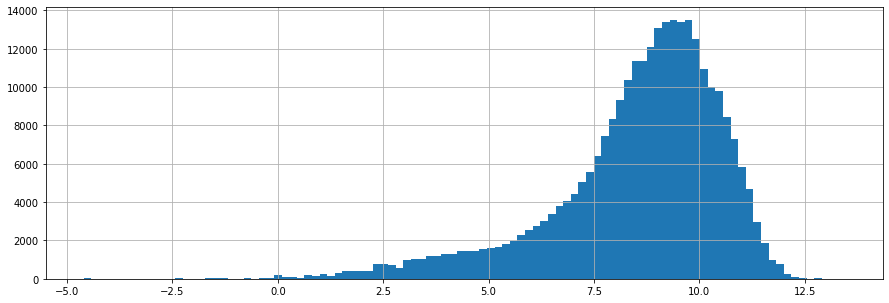

In [56]:
SHIFT = 0
df_sales_train['weekly_sales_log'] = df_sales_train['weekly_sales'].apply(lambda x: np.log(x+SHIFT))
df_sales_train['weekly_sales_log'].hist(bins=100);

In [57]:
list(df_sales_test.columns)

['id',
 'store',
 'dept',
 'date',
 'is_holiday',
 'week',
 'month',
 'store_mean',
 'store_std',
 'store_median',
 'store_agg_size',
 'dept_mean',
 'dept_std',
 'dept_median',
 'dept_agg_size',
 'temperature_mean',
 'fuel_price_mean',
 'fuel_price_median',
 'fuel_price_std',
 'unemployment_mean',
 'unemployment_median',
 'unemployment_std',
 'cpi_mean',
 'cpi_median',
 'cpi_std',
 'type',
 'store_size',
 'type_factorized',
 'year',
 'year_plus_1',
 'prev_year_sales',
 'czy_sa_dane_o_sprzedazy_prev_year']

In [58]:
cechy_do_uczenia = [
    'store', 'dept', 'is_holiday', 'week', 'month',
    'store_mean',
    'store_std',
    'store_median',
    'store_agg_size',
    'dept_mean',
    'dept_std',
    'dept_median',
    'dept_agg_size',
    'temperature_mean', 
    'fuel_price_mean',
    'fuel_price_median',
    'fuel_price_std',
    'unemployment_mean',
    'unemployment_median',
    'unemployment_std',
    'cpi_mean',
    'cpi_median',
    'cpi_std',
    'store_size', 
    'type_factorized',
    'czy_sa_dane_o_sprzedazy_prev_year',
    # 'prev_year_sales',  # tam są w środku NaN-y, ale dodane z premedytacją
]

In [59]:
# własna funkcja straty dla xgboost
def fair_obj(y_true, preds):
    labels = y_true  # .get_labels()
    x = preds - labels
    c = 0.7
    den = abs(x) + c
    grad = c*x / (den)
    hess = c*c / den*den
    return grad, hess

In [60]:
def mae_log_eval(y_log_pred, dtrain):
    y_log_true = dtrain.get_label()
    shift = SHIFT
    y_true = np.exp(y_log_true) - shift
    y_pred = np.exp(y_log_pred) - shift
    return 'mae', mean_absolute_error(y_true, y_pred)

In [61]:
def testuj_model(X, y, model, cv=3):
    # UWAGA: dla timeseries nie należy walidować danych w ten sposób !!!
    # W ten sposób do walidacji przeszłych punktów używamy przyszłych danych.
    cv = KFold(n_splits=cv, shuffle=True, random_state=42)

    scores = []

    for train_idx, test_idx in cv.split(X):
        X_train_cv, X_test_cv = X[train_idx], X[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]

        eval_set = [(X_train_cv, y_train_cv),
                    (X_test_cv, y_test_cv)]

        model.fit(X_train_cv, y_train_cv, eval_metric=mae_log_eval,
                  eval_set=eval_set,
                  verbose=10)

        y_pred = model.predict(X_test_cv)
        y_pred_fin = np.exp(y_pred) - SHIFT
        y_test_fin = np.exp(y_test_cv) - SHIFT
        error = mean_absolute_error(y_test_fin, y_pred_fin)
        print(f'Mean absolute error: {error:.5f}')
        scores.append(error)

    print('Model:')
    print(model)
    print(f'Średni błąd:\t{np.mean(scores):.05f}')
    print(f'StdDev błąd:\t{np.std(scores):.05f}')

    return np.mean(scores)

In [62]:
def testuj_model2(X, y, model):
    rozm = len(X)
    test_size = int(rozm * 0.3)
    train_size = rozm - test_size
    
    X_train_cv = X[:train_size]
    y_train_cv = y[:train_size]
    
    X_test_cv = X[train_size:]
    y_test_cv = y[train_size:]
    
    eval_set = [(X_train_cv, y_train_cv),
                (X_test_cv, y_test_cv)]
    
    model.fit(X_train_cv, y_train_cv, eval_metric=mae_log_eval,
              eval_set=eval_set,
              verbose=10)

    y_pred = model.predict(X_test_cv)
    y_pred_fin = np.exp(y_pred) - SHIFT
    y_test_fin = np.exp(y_test_cv) - SHIFT
    error = mean_absolute_error(y_test_fin, y_pred_fin)

    print('Model:')
    print(model)
    print(f'Mean absolute error: {error:.5f}')
    
    return error    

In [63]:
df_sales_train.sort_values('date', inplace=True)
df_sales_test.sort_values('date', inplace=True)

X_train = df_sales_train[cechy_do_uczenia].values
X_test = df_sales_test[cechy_do_uczenia].values

y_train = df_sales_train['weekly_sales_log'].values

In [64]:
# moje szczęśliwe parametry, z braku czasu skopiowane z jakiegoś innego modelu. Noe były optymalizowane an tym modelu
xgb_params ={
    # 'objective': fair_obj,
    'max_depth': 14,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'min_child_weight': 3.0,
    'reg_alpha': 1.010560518922879,
    'reg_lambda': 0.9990634429213564,
    'subsample': 0.9669849576928992,
    'random_state': 0
}

In [65]:
model = xgb.XGBRegressor(**xgb_params)

In [66]:
testuj_model2(X_train, y_train, model)

[0]	validation_0-rmse:7.46464	validation_0-mae:15986.58691	validation_1-rmse:7.45134	validation_1-mae:16098.63672
[10]	validation_0-rmse:2.63446	validation_0-mae:15249.65723	validation_1-rmse:2.65162	validation_1-mae:15362.72461
[20]	validation_0-rmse:0.97631	validation_0-mae:10697.12109	validation_1-rmse:1.06326	validation_1-mae:10818.63672
[30]	validation_0-rmse:0.44167	validation_0-mae:5355.95703	validation_1-rmse:0.63632	validation_1-mae:5565.46826
[40]	validation_0-rmse:0.29343	validation_0-mae:2568.56860	validation_1-rmse:0.55848	validation_1-mae:2981.39893
[50]	validation_0-rmse:0.25085	validation_0-mae:1647.19519	validation_1-rmse:0.54462	validation_1-mae:2168.99585
[60]	validation_0-rmse:0.23176	validation_0-mae:1388.91321	validation_1-rmse:0.54132	validation_1-mae:1938.18286
[70]	validation_0-rmse:0.21799	validation_0-mae:1263.09485	validation_1-rmse:0.53923	validation_1-mae:1828.37085
[80]	validation_0-rmse:0.20870	validation_0-mae:1191.74011	validation_1-rmse:0.53784	valida

1603.0318832149705

In [67]:
model_final = xgb.XGBRegressor(**xgb_params)
model_final.fit(X_train, y_train, eval_metric=mae_log_eval, verbose=10)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=14, min_child_weight=3.0, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=1.010560518922879, reg_lambda=0.9990634429213564,
             scale_pos_weight=1, subsample=0.9669849576928992,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
y_pred = model_final.predict(X_test)

In [69]:
df_sales_test["weekly_sales"] = np.exp(y_pred)

In [ ]:
df_sales_test['weekly_sales_mean'] = df_sales_test.apply(lambda row: np.nanmean([row['weekly_sales'], row['prev_year_sales']]), axis=1)

In [ ]:
# df_sales_test[['id', 'weekly_sales_mean']].to_csv(r'../output/late_submission_11_mean.csv', index=False)

In [ ]:
df_sales_test[['id', 'weekly_sales']].to_csv(r'../output/late_submission_13.csv', index=False)